<a href="https://colab.research.google.com/github/smcifuentesm/ProjectDS4/blob/master/Copy_of_projectds4a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%time 
!apt update --quiet
!apt upgrade --quiet
# GDAL Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal --quiet
# Install rtree - Geopandas requirment
!apt install python3-rtree --quiet
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet
# Install descartes - Geopandas requirment
!pip install descartes --quiet
# Install Folium for Geographic data visualization
!pip install folium --quiet
# Install Pysal
!pip install pysal --quiet
# Install splot --> pysal
!pip install splot --quiet
# Install mapclassify
!pip install mapclassify --quiet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:13 https://developer.download.nvidia.com/c

In [3]:
#import pandas as pd
#import pandas.io.sql as sqlio
#import psycopg2
#import numpy as np
#import matplotlib
#import matplotlib.pyplot as plt
#import seaborn as sns
#import missingno
#import folium 
#from folium import plugins
#from folium.plugins import HeatMap
#from geopy.geocoders import Nominatim
#%matplotlib inline

In [4]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from pysal.explore import esda
from pysal.lib import weights
#import libysal as lps
#from pysal.viz.splot.esda import plot_moran, plot_local_autocorrelation, lisa_cluster
import matplotlib
import matplotlib.pyplot as plt 

import folium
from folium import plugins
from folium.plugins import HeatMap

import os
import seaborn as sns
#from sklearn.cluster import KMeans
from sklearn.cluster import dbscan

from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster

import pysal as ps
ps.__version__

import missingno
from geopy.geocoders import Nominatim

from geopandas.tools import geocode

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
%matplotlib inline

In [5]:
username="taxisrcp_user"
password="123123123"
host="ds4ataxisrcp.col3gdd6vsxk.us-east-2.rds.amazonaws.com"
port="5432"
dbname="taxisrcp_db"
try:
    connection = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, password))
    sql = '''select s.id, s.creado fecha, 
              tp.parametro estado, 
              s.tipo_servicio,
              dir.numero directorio,
              direc.direccion_completa direccion,
              direc.latitud,
              direc.longitud,
              b.barrio,
              p.nombres,
              p.genero
            from mastermind_solicitud s 
            inner join parametrizacion_tipoparametro tp on s.status_id = tp.id
            left join administracion_directorio dir on s.directorio_id=dir.id
            left join administracion_perfil p on dir.perfil_id=p.id
            left join administracion_direccion direc on dir.direccion_id = direc.id::integer
            left join administracion_barrio b on direc.barrio_id::integer = b.id'''   
    df = sqlio.read_sql_query(sql, connection)
    #sql = "select * from administracion_directorio"
    #df_directorio = sqlio.read_sql_query(sql, connection)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    #closing database connection.
    if(connection):
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [7]:
df_taxisrcp = pd.DataFrame(df)

In [8]:
df_taxisrcp

,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero
0,2,2017-02-06 16:43:35.662873,Activa,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.28633259999998,Las Margaritas,None,None
1,4,2017-02-06 16:44:43.138051,Activa,SC,7370426,MZ C CS 02 CONJ. TEQUENDAMA,NaN,None,None,None,None
2,5,2017-02-06 16:45:10.072257,Confirmada,SC,1508,TORRE ANDINA,NaN,None,Avenida Boyaca,None,None
3,8,2017-02-06 16:48:26.053794,Confirmada fuera de tiempo,SC,7316085,Carrera 43 16C 25 REFUGIO VALLE DE ATRIZ ♠♦,1.224355,-77.2903005,None,None,None
4,19,2017-02-06 17:03:48.711795,Confirmada,SC,7370509,Calle 19 D # 43 - 82 PORTAL VALLE DE ATRIZ,1.230575,-77.2876999,Valle De Atriz,None,None
...,...,...,...,...,...,...,...,...,...,...,...
2436910,2437153,2020-08-18 23:31:33.353695,Activa,SC,3006026575,Manzana 37 cs 14 cha,NaN,None,None,None,None
2436911,2437154,2020-08-18 23:33:26.070070,Activa,SC,3188443434,c 15 23 47,NaN,None,None,None,None
2436912,2437160,2020-08-18 23:35:13.100688,Activa,SC,3164903341,Calle 16 # 16a - 67,NaN,None,None,None,None
2436913,2437183,2020-08-19 00:08:21.578043,Activa,SC,3162427945,Carrera 47 17 23 HOTEL CAFÉ Y MIEL,NaN,None,Universitario,None,None


In [13]:
df_taxisrcp.replace('nan',np.NaN,inplace=True)
df_taxisrcp.replace('None',np.NaN,inplace=True)

In [14]:
df_taxisrcp.info()
df_taxisrcp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2436915 entries, 0 to 2436914
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             int64         
 1   fecha          datetime64[ns]
 2   estado         category      
 3   tipo_servicio  category      
 4   directorio     object        
 5   direccion      object        
 6   latitud        float64       
 7   longitud       float64       
 8   barrio         object        
 9   nombres        object        
 10  genero         category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 155.7+ MB


,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero
0,2,2017-02-06 16:43:35.662873,Activa,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.286333,Las Margaritas,None,NaN
1,4,2017-02-06 16:44:43.138051,Activa,SC,7370426,MZ C CS 02 CONJ. TEQUENDAMA,NaN,NaN,None,None,NaN
2,5,2017-02-06 16:45:10.072257,Confirmada,SC,1508,TORRE ANDINA,NaN,NaN,Avenida Boyaca,None,NaN
3,8,2017-02-06 16:48:26.053794,Confirmada fuera de tiempo,SC,7316085,Carrera 43 16C 25 REFUGIO VALLE DE ATRIZ ♠♦,1.224355,-77.290301,None,None,NaN
4,19,2017-02-06 17:03:48.711795,Confirmada,SC,7370509,Calle 19 D # 43 - 82 PORTAL VALLE DE ATRIZ,1.230575,-77.287700,Valle De Atriz,None,NaN


The output shows that we have around 2.4 million entries with 10 columns. There are some columns with null values. The data type of columns have the same type so we need to to set up the correct data type.

# **Setting the data types correctly**

In [15]:
df_taxisrcp['fecha'] = pd.to_datetime(df_taxisrcp['fecha'])
df_taxisrcp['estado'] = df_taxisrcp['estado'].astype('category')
df_taxisrcp['tipo_servicio'] = df_taxisrcp['tipo_servicio'].astype('category')
df_taxisrcp['latitud'] = df_taxisrcp['latitud'].astype('float64')
df_taxisrcp['longitud'] = df_taxisrcp['longitud'].astype('float64')
df_taxisrcp['genero'] = df_taxisrcp['genero'].astype('category')

In [16]:
df_taxisrcp.info()
df_taxisrcp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2436915 entries, 0 to 2436914
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             int64         
 1   fecha          datetime64[ns]
 2   estado         category      
 3   tipo_servicio  category      
 4   directorio     object        
 5   direccion      object        
 6   latitud        float64       
 7   longitud       float64       
 8   barrio         object        
 9   nombres        object        
 10  genero         category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 155.7+ MB


,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero
0,2,2017-02-06 16:43:35.662873,Activa,SC,1342,Calle 16 # 37 - 47 Las Margaritas,1.220376,-77.286333,Las Margaritas,None,NaN
1,4,2017-02-06 16:44:43.138051,Activa,SC,7370426,MZ C CS 02 CONJ. TEQUENDAMA,NaN,NaN,None,None,NaN
2,5,2017-02-06 16:45:10.072257,Confirmada,SC,1508,TORRE ANDINA,NaN,NaN,Avenida Boyaca,None,NaN
3,8,2017-02-06 16:48:26.053794,Confirmada fuera de tiempo,SC,7316085,Carrera 43 16C 25 REFUGIO VALLE DE ATRIZ ♠♦,1.224355,-77.290301,None,None,NaN
4,19,2017-02-06 17:03:48.711795,Confirmada,SC,7370509,Calle 19 D # 43 - 82 PORTAL VALLE DE ATRIZ,1.230575,-77.287700,Valle De Atriz,None,NaN


# **Missing values and Duplicated Entries**

In [17]:
df_taxisrcp.isna().sum()

id                     0
fecha                  0
estado                 0
tipo_servicio          0
directorio            74
direccion           2064
latitud          1897029
longitud         1897029
barrio           1509617
nombres          2431279
genero           2433075
dtype: int64

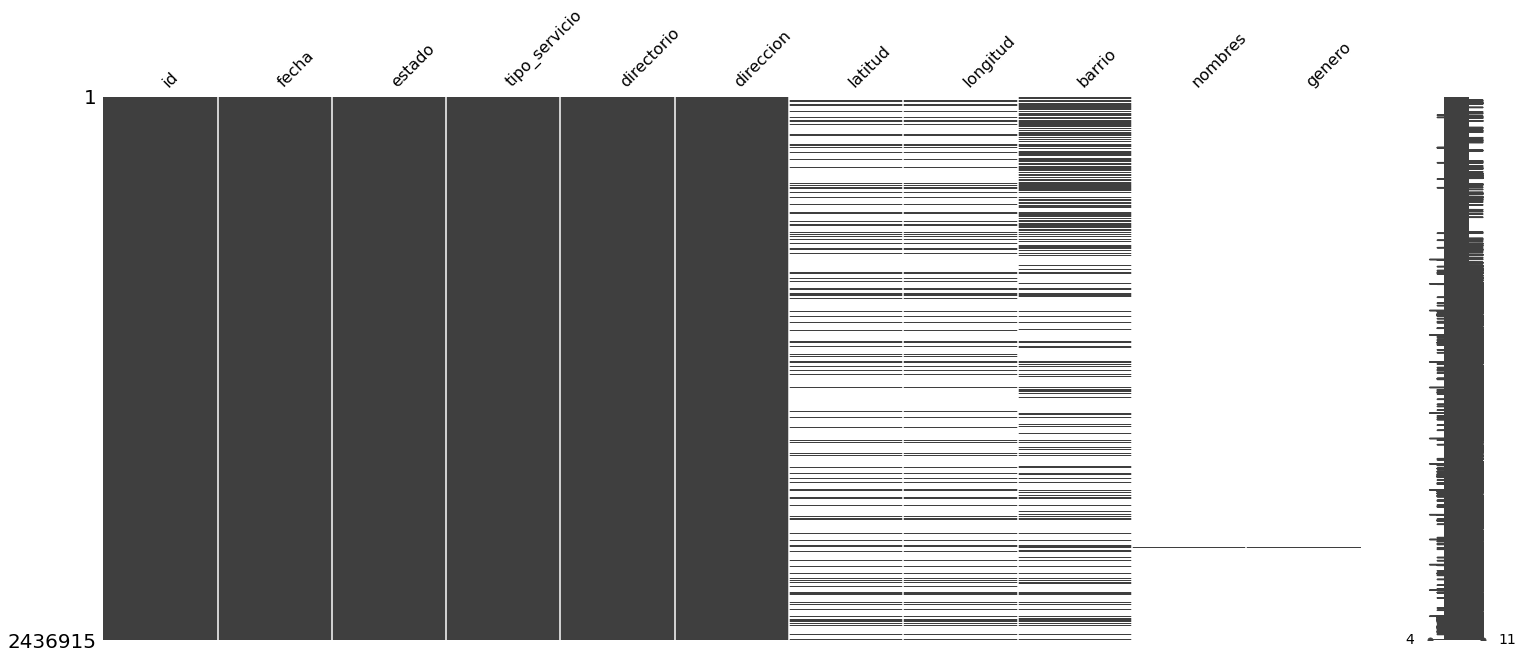

In [18]:
if len(df_taxisrcp[df_taxisrcp.isnull().any(axis=1)] != 0):
  missingno.matrix(df_taxisrcp)
  plt.show()

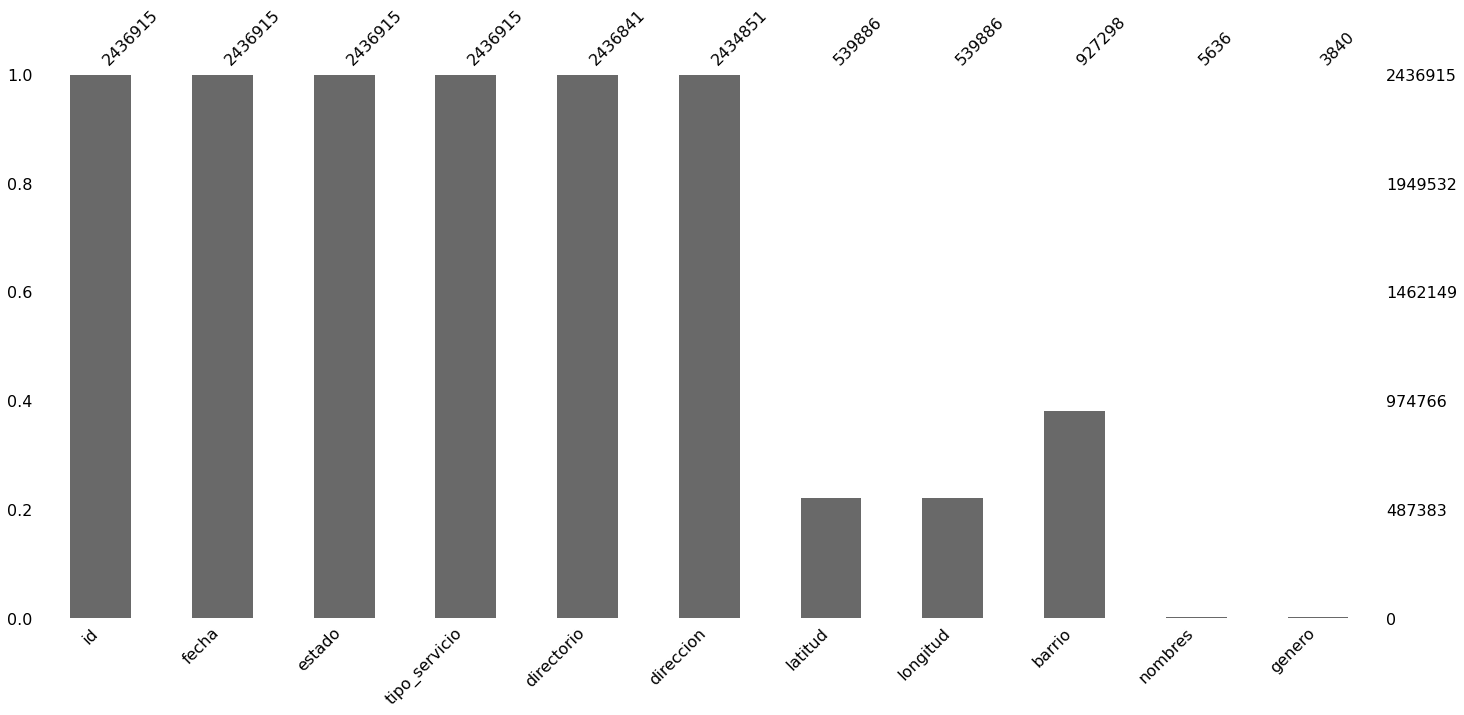

In [19]:
missingno.bar(df_taxisrcp)

In [20]:
# generate count statistics of duplicate entries
if len(df_taxisrcp[df_taxisrcp.duplicated()]) > 0:
  print("\n***Number of duplicated entries: ", len(df_taxisrcp[df_taxisrcp.duplicated()]))
  display(df_taxisrcp[df_taxisrcp.duplicated(keep=False)].sort_values(by=list(df_taxisrcp.columns)).head())
else:
  print("\nNo duplicated entries found")



No duplicated entries found


Drop rows with direccion values null

In [21]:
df_test = df_taxisrcp[df_taxisrcp['direccion'].isnull()].copy()


In [22]:
df_taxisrcp.dropna(subset=['direccion'],inplace=True)

In [23]:
df_taxisrcp.isna().sum()

id                     0
fecha                  0
estado                 0
tipo_servicio          0
directorio            10
direccion              0
latitud          1894965
longitud         1894965
barrio           1507553
nombres          2431011
genero           2431011
dtype: int64

In [24]:
df.shape

(2436915, 11)

In [25]:
df_latlon = df_taxisrcp.dropna(subset=['latitud','longitud'])


-----------------

In [26]:
df_latlon.isna().sum()

id                    0
fecha                 0
estado                0
tipo_servicio         0
directorio           10
direccion             0
latitud               0
longitud              0
barrio            56708
nombres          537145
genero           537145
dtype: int64

In [27]:
df_latlon.shape

(539886, 11)

# **Detecting outliers**

In [28]:
coords = taxi_gdf[['latitud', 'longitud']]
coords[:5]

NameError: ignored

In [29]:
# Get labels of each cluster 
_, labels  = dbscan(taxi_gdf[['latitud', 'longitud']], eps=0.1, min_samples=10)

NameError: ignored

In [ ]:
# Create a labels dataframe with the index of the dataset
labels_df = pd.DataFrame(labels, index=taxi_gdf.index, columns=['cluster'])
labels_df.head()

NameError: ignored

In [ ]:
labels_df.groupby('cluster').size()

# **Categorical data analysis**

In [30]:
df_taxisrcp.select_dtypes(include=['category']).nunique()

estado           5
tipo_servicio    4
genero           2
dtype: int64

In [31]:
columns = df_taxisrcp.select_dtypes(include=[ 'category']).columns
for col in columns:
    print("Unique values of " + col)
    print(df_taxisrcp[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"}))
    print("")

Unique values of estado
                       estado   Count
0                  Confirmada  944040
1  Confirmada fuera de tiempo  654552
2                      Activa  433976
3                    Generada  383428
4                   Cancelada   18855

Unique values of tipo_servicio
  tipo_servicio    Count
0            SC  2432762
1           SEU     1714
2           SEA      339
3           SEI       36

Unique values of genero
  genero  Count
0      M   3743
1      F     97



Estado


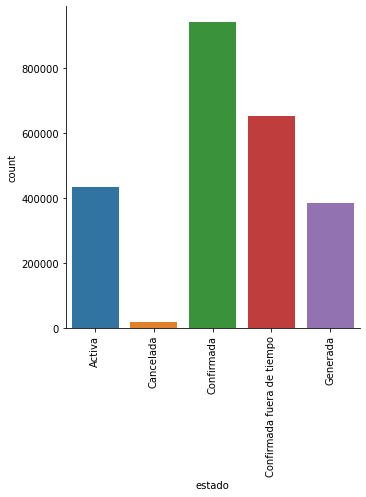

In [32]:
print('Estado')
fig = sns.catplot(x='estado', kind="count", data=df_taxisrcp)
fig.set_xticklabels(rotation=90)
plt.show()  
    

Distribution of estado data


<Figure size 1440x720 with 0 Axes>

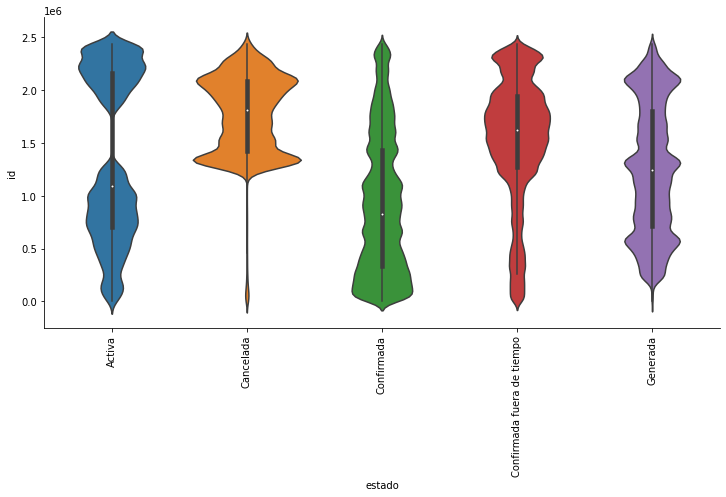

In [ ]:
print("Distribution of estado data")
figure = plt.figure(figsize=(20, 10))
fig = sns.catplot(x='estado', y='id', kind='violin', data=df_taxisrcp, height=5, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

tipo_servicio


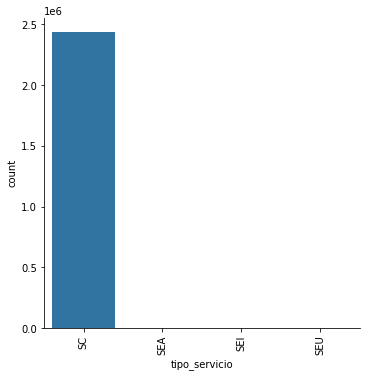

In [ ]:
print('tipo_servicio')
fig = sns.catplot(x='tipo_servicio', kind="count", data=df_taxisrcp)
fig.set_xticklabels(rotation=90)
plt.show()

Distribution of tipo_servicio data


<Figure size 1440x720 with 0 Axes>

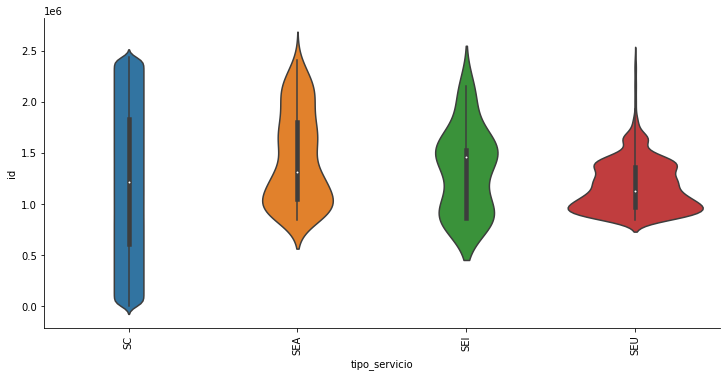

In [ ]:
print("Distribution of tipo_servicio data")
figure = plt.figure(figsize=(20, 10))
fig = sns.catplot(x='tipo_servicio', y='id', kind='violin', data=df_taxisrcp, height=5, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

genero


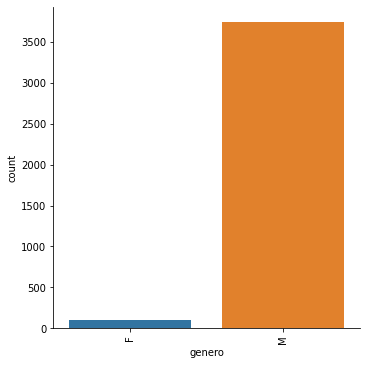

In [ ]:
print('genero')
fig = sns.catplot(x='genero', kind="count", data=df_taxisrcp)
fig.set_xticklabels(rotation=90)
plt.show()

Distribution of genero data


<Figure size 1440x720 with 0 Axes>

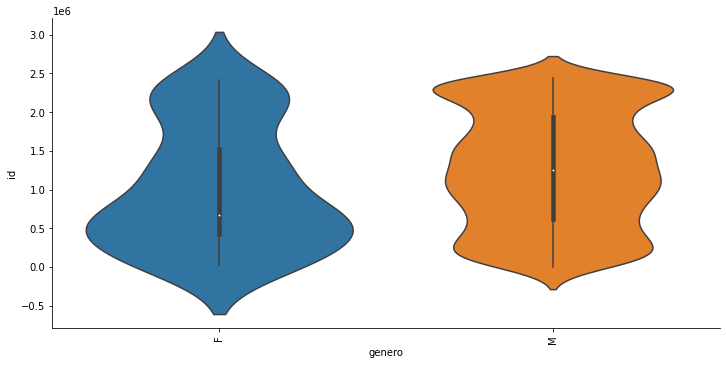

In [ ]:
print("Distribution of genero data")
figure = plt.figure(figsize=(20, 10))
fig = sns.catplot(x='genero', y='id', kind='violin', data=df_taxisrcp, height=5, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

------------------

# **Geospatial analysis**

In [33]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
# Function to create a Geodataframe. This code was taken from Geospatial-Data-Science-Quick-Start-Guide book
def create_gdf(df, lat, lon):
  """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
  crs = {'init': 'epsg:4326'}
  geometry = [Point(xy) for xy in zip(df[lon], df[lat])]
  gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
  return gdf


In [34]:
taxi_gdf = create_gdf(df_latlon, 'latitud', 'longitud')
taxi_gdf.head()

NameError: ignored

In [ ]:
fname = '/content/drive/My Drive/Colab Notebooks/pasto.geojson' # Your filepath here
polyPasto = gpd.read_file(fname)
polyPasto.set_crs(epsg=4326, inplace=True)
polyPasto.head()

,geometry
0,GEOMETRYCOLLECTION (MULTIPOLYGON (((-77.36573 ...


In [ ]:
from geopandas.tools import sjoin

pointInPolyPasto = sjoin(taxi_gdf,polyPasto, how='inner')
pointInPolyPasto.head()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [35]:
pasto_latitude, pasto_longitude = 1.21361,-77.28111

# define the world map centered around pasto COlombia with a higher zoom level width=550,height=550,
pasto_map = folium.Map(location=[pasto_latitude, pasto_longitude], zoom_start=8)
icon_taxi = plugins.BeautifyIcon(
    icon='taxi',
    border_color='#b3334f',
    text_color='#b3334f',icon_shape= 'marker')

def plotMarket(point):
  folium.Marker(
      location=[point.latitud, point.longitud],
      popup=point.direccion
  ).add_to(pasto_map)

df_geo.apply(plotMarket, axis = 1)
# display world map
pasto_map

NameError: ignored

In [36]:
comuna1=[""]
comuna2
comuna3
comuna4
comuna5
comuna6
comuna7
comuna8
comuna9
comuna10
comuna11
comuna12


df_taxisrcp

NameError: ignored

In [37]:
comuna1=["avenida boyaca", "avenida santander", "bombona", "caracha", "centro", "condominio santiado", "churo", "portalito", "parque", "centro",
         "condominio santiago", "cilindro", "hullaguanga", "panaderia", "americas", "dos puentes", "marcos de la rosa", "san agustin centro", "san andres", "san andresito", "san jose", 
         "jose obrero", "santiago", "miravalle"]


df_taxisrcp["direccion"]=df_taxisrcp["direccion"].str.lower()

for i in comuna1:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 1


comuna2=["alhambra", "aire libre", "atahualpa", "avenida champagnat", "avenida colombia", "bella vista", "casa bella", "coliseo cubierto", "olivo", "prado", "recuerdo", "fatima", "javeriano", "julian Bucheli", "gran colombia",
 "lunas",  "violetas",  "abedules", "alamos",  "balcones", "olivos", "medardo bucheli", "navarrete", "normandia", "parque bolivar", "salomon", "san miguel",  "juan bosco", "villa lucia"]

for i in comuna2:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 2


In [38]:
comuna3=["alejandria", "arnulfo guerrero", "caicedonia", "camilo torres", "casa Loma", "ejido", "guamuez", "jose antonio galan", "esmeralda", "estrella",  "brisas", "lajas", "mercedes", "pinos", "mercedario", "pie de cuesta", "pinar del rio", "popular", "pucalpa",
   "rosal del  oriente", "santa barbara", "santa catalina", "santa monica", "villa oriente", "villa flor"]

for i in comuna3:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 3




In [39]:
comuna4=["albergue del sol", "altos de lorenzo", "altos del campo", "avenida idema", "belen", "bernal", "betania", "chile", "doce de octubre", "porvenir", "rosario", "tejar", "triunfo",  "paz"
"laureano gomez", "lorenzo de aldana", "eliseos", "miraflores", "praga", "puerta del sol", "rincon colonial", "san german" ,"san juan de los pastos" ,"santa fe", "santacruz", "sendoya" ,"siete de agosto", "villa olimpica", "villa victoria", "villa docente"]

for i in comuna4:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 4





In [40]:
comuna5=["altos de chapalito", "antonio nariño", "cantarana", "chambu", "chapal",  "pilar", "progreso", "remanso", "emilio botero", "minga", "la rosa", "vega", "ferias", "cristales", "robles", "madrigal", "maria isabel", "potrerillo", "prados del sur", "salida al sur",
 "san martin", "santa clara", "venecia", "villa del rio", "vivienda cristiana"]

for i in comuna5:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 5








In [41]:
comuna6=["agualongo", "altamira", "bachue", "caicedo", "ciudad jardin", "popular nariñense", "estadio", "libertador", "gilberto pabon", "granada", "inem", "jerusalen", "cruz", "palma", "fundadores", "luis carlos galan", "mijitayo", 
"mirador de niza", "niza", "nueva colombia"" prados del niza", "quillacinga", "quito lopez", " san carlos", "san miguel de jongovito", "san sebastian", "santa isabel", "santanita", "sumatambo", "tamasagra", "tequendama",
"valle lili", "villa de los rios"]

for i in comuna6:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 6



In [42]:

comuna7=["achalay", "avenida panamericana", "capusigra", "castillos  del norte", "conjunto el parque", "bosque", "eden", "rincon de la aurora", "rincon de la panamericana", "francisco de la villota", "la aurora", "primavera", "acacias",
"camelias", "andes", "hexagonos", "rosales", "san felipe", "san ignacio", "santa maria", "villa aurora", "villa campanela", "villa sofia", "villa vergel"]

for i in comuna7:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 7




In [43]:
comuna8=["altamira", "san vicente", "alta vista", "altos de la colina", "anganoy", "arcos iris", "balcones de mariluz", "bello horizonte", "colon", "colpatria", "conjunto san diego", "el remanso del norte", "gualcaloma", "jorge giraldo", 
"castellana", "cuesta", "pradera", "margaritas", "frailejones", "heroes", "laureles", "urapanes","mariluz", "mirador de san juan", "miravalle", "montemor", "panamericano", "san pedro",  "portal de la colina", "prados del oeste", "quintas de san pedro",
"remansos del norte", "salazar mejia", "san diego", "san juan de anganoy", "san juan de dios", "sindamanoy", "torres de pubenza", "veracruz", "villa jardin", "villas de san rafael"]

for i in comuna8:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 8



In [44]:
comuna9=["alto juanoy", "los estudiantes", "briceno", "calatrava", "camino real", "castilla", "chapultepec", "colonial", "condominio morasurco", "conjunto torobajo", "aljibe", "ceramico", "dorado", "mirador", "polvorin", "refugio", 
"figueroa", "jose ignacio zarama", "juan xxiii", "juanoy", "la colina", "riviera", "cuadras", "victoria", "nogales", "sauces", "luis brand", "manaca", "maridiaz", "marsella", "morasurco", "nuevo amanecer", "palermo", "pandiaco",
"parana", "parque infantil", "pinos del norte", "portal de la colina", "san antonio de juanoy", "santa ana", "santa rita", "sañudo", "tequendama", "terranova", "terrazas de briceño", "titan", "torobajo", "universitario", "zarama", 
"valle de atriz", "versalles", "villa campestre", "villa maria"]

for i in comuna9:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 9






In [45]:
comuna10=["aranda", "avenida aranda", "avenida oriental", "avenida oriental rio pasto", "buenos aires", "cementerio", "condominio bellavista", "corazon de jesus", "cra 27 a del barrio centenario", "destechados", "futuro", "portal de aranda",
"portal del norte", "rincon de pasto", "rincon del rosario", "juan pablo", "esperanza", "floresta", "libertad", "loma del carmen",  "marquetalia", "niño jesus de praga", "nueva aranda", "nuevo horizonte", "nuevo sol", "ocho de marzo", 
"prados del norte", "quebrada gallinacera", "quillotocto", "rincon de aranda", "rio blanco", "san albano", "santa matilde", "sector pedagogico", "sol de oriente", "termina sector peatonal 28", "tescual", "villa del rosario", "villa guerrero", 
 "villas del norte"]

for i in comuna10:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 10




In [46]:

comuna11=["alameda", "Aquine",  "belalcazar", "centenario", "chico", "ciudad real", "corazon de jesus", "calvario", "el comun", "corralito", "hospital civil", "floresta", "lomita", "alcazares", "rincon del paraiso", "salsipuedes", "villa elena", 
"villa jazmin"]

for i in comuna11:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 11



In [47]:
comuna12=["la carolina", "altos de la carolina", "balcones del este", "campiña de oriente", "carlos pizarro", "cujacal bajo", "manantial", "paraiso", "fray ezequiel moreno diaz", "gualcala","florida", "josefina", "orquideas", "maria paz", 
"monserrat", "parque de baviera", "san diego norte", "san mateo", "sena", "simon bolivar", "sindagua", "villa colombia", "villa adriana maria", "villa angela", "villa del prado", "villa recreo", "villa rocio"]

for i in comuna12:
  mask = df_taxisrcp['direccion'].str.contains(i)
  df_taxisrcp.loc[mask, 'barrio'] = i
  df_taxisrcp.loc[mask, 'comuna'] = 12



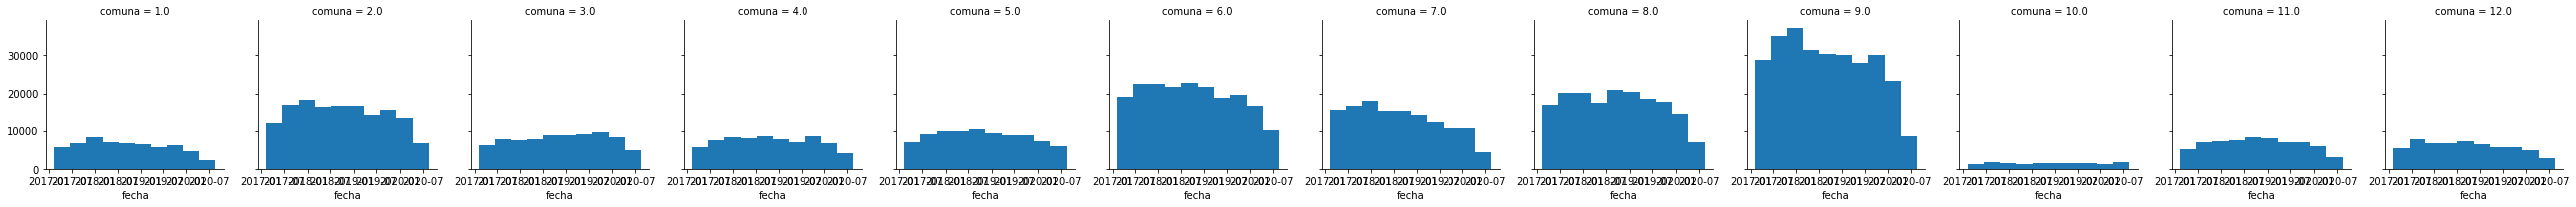

In [ ]:
%matplotlib inline

df_taxisrcp.groupby("comuna").count()
g = sns.FacetGrid(df_taxisrcp, col="comuna")
g.map(plt.hist, "fecha")

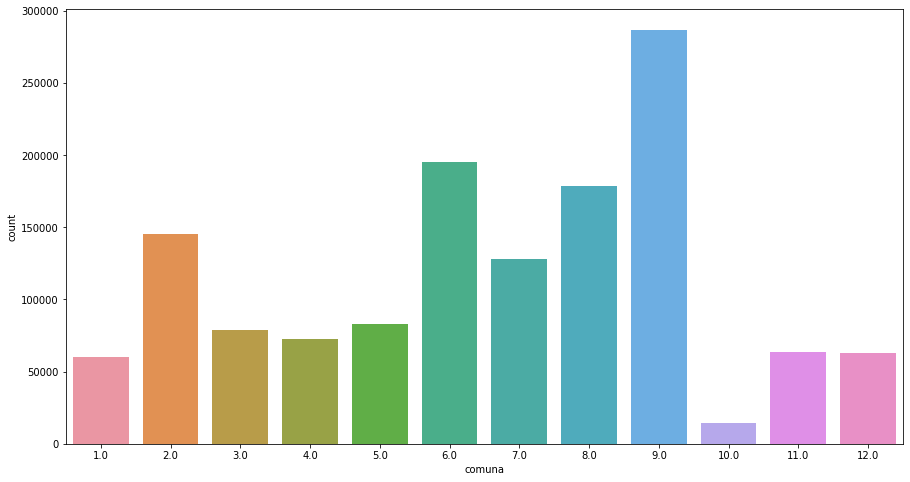

In [ ]:

fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(x='comuna', data=df_taxisrcp)

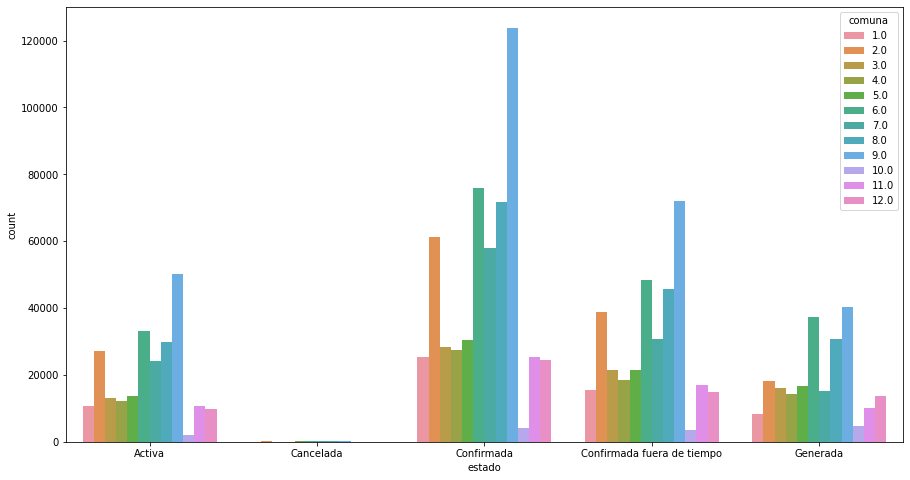

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(x='estado', data=df_taxisrcp, hue="comuna")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


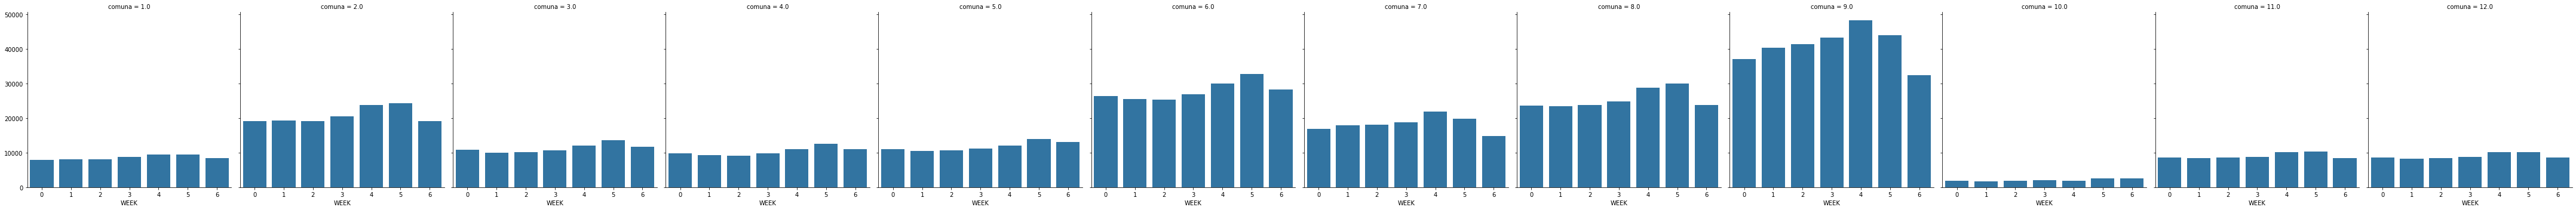

In [ ]:





df_taxisrcp['MONTHYEAR']=df_taxisrcp.fecha.dt.to_period(freq="M")

df_taxisrcp['WEEK']=df_taxisrcp['fecha'].dt.weekday


#df_taxisrcp.groupby("comuna").count()
g = sns.FacetGrid(df_taxisrcp, col="comuna", height=5, aspect=1)

g.map(sns.countplot, "WEEK")

In [ ]:
df_taxisrcp


,id,fecha,estado,tipo_servicio,directorio,direccion,latitud,longitud,barrio,nombres,genero,comuna,MONTHYEAR,WEEK
0,1684494,2019-06-15,Confirmada fuera de tiempo,SC,1342,calle 16 # 37 - 47 las margaritas,1.220376,-77.286333,margaritas,None,NaN,8.0,2019-06,5
1,1684511,2019-06-15,Confirmada,SC,1024,torres de mariluz,NaN,NaN,mariluz,None,NaN,8.0,2019-06,5
2,1684513,2019-06-15,Confirmada fuera de tiempo,SC,7293074,miravalle,NaN,NaN,miravalle,None,NaN,8.0,2019-06,5
3,1684520,2019-06-15,Confirmada fuera de tiempo,SC,3013488266,carrera 24 13 54 santiago,NaN,NaN,santiago,None,NaN,1.0,2019-06,5
4,1684525,2019-06-15,Confirmada fuera de tiempo,SC,1011,carrera 35 19 10 habitar versalles,NaN,NaN,versalles,None,NaN,9.0,2019-06,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436910,1684278,2019-06-15,Confirmada fuera de tiempo,SC,3177203316,canchala,NaN,NaN,None,None,NaN,NaN,2019-06,5
2436911,1684341,2019-06-15,Confirmada fuera de tiempo,SC,3165780828,carrera 18 13a 24,NaN,NaN,None,None,NaN,NaN,2019-06,5
2436912,1684398,2019-06-15,Confirmada fuera de tiempo,SC,3013922758,carreraa 41 9 25 m/3,NaN,NaN,None,None,NaN,NaN,2019-06,5
2436913,1684449,2019-06-15,Confirmada fuera de tiempo,SC,3015410836,calle 19 # 17b - 58,NaN,NaN,None,None,NaN,NaN,2019-06,5


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


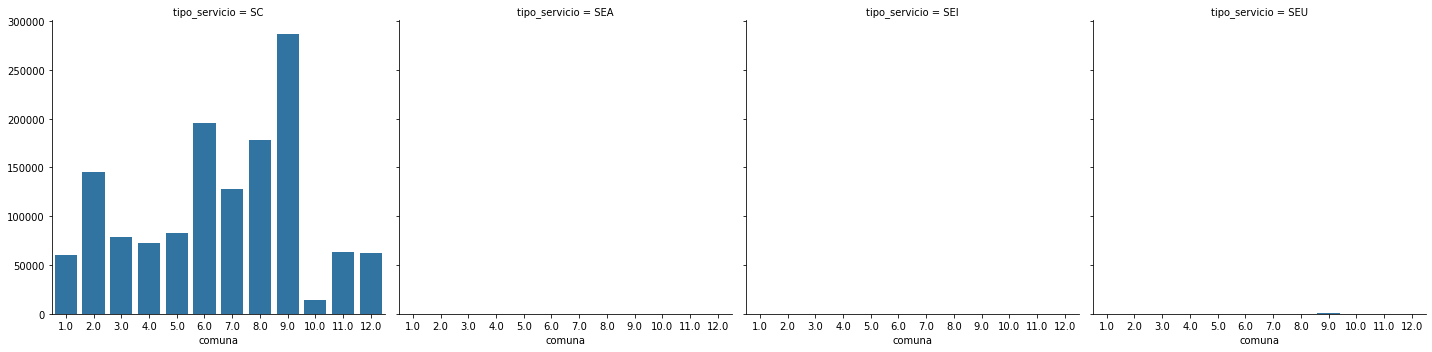

In [ ]:
g = sns.FacetGrid(df_taxisrcp, col="tipo_servicio", height=5, aspect=1)

g.map(sns.countplot, "comuna")

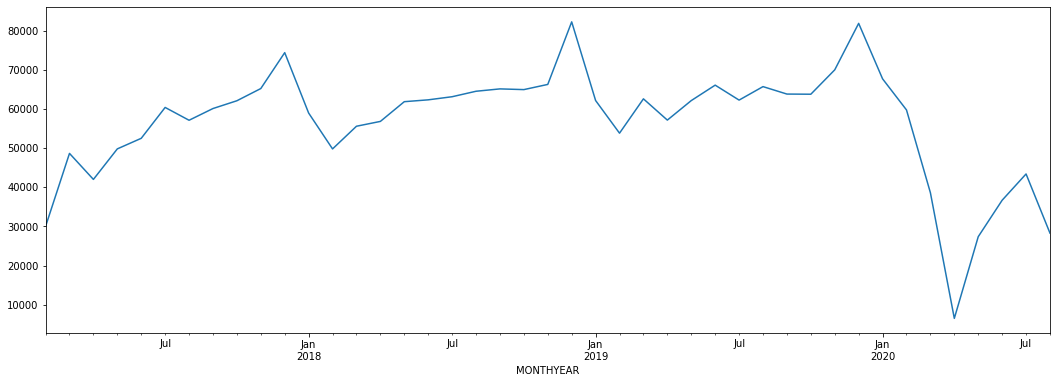

In [ ]:
plt.subplots(figsize=(18,6))
df_taxisrcp.groupby(["MONTHYEAR"]).size().plot()


In [ ]:
df_taxisrcp.groupby(["barrio"]).size().sort_values(axis=0, ascending=True).head(30)
                                                                            

barrio
Sena                              1
Carlos Pizarro                    1
Casa Bella                        1
Cra 27 A Del Barrio Centenario    1
Cujacal Bajo                      1
Doce De Octubre I                 1
ocho de marzo                     1
Emilio Botero I                   1
Emilio Botero III                 1
marquetalia                       1
castillos  del norte              1
Miravalle                         1
villa del prado                   1
Nueva Betania                     1
Mocondino Centro (Cabecera)       1
Popular                           1
Santa Isabel                      1
Torres de Pubenza                 1
San José de Catambuco             1
Villa Aurora                      1
Villa Jardín                      1
Rio Blanco                        1
Altamira – San Vicente            1
Quillotocto                       1
Prados Del Sur                    1
juan xxiii                        2
Fray Ezequiel Moreno Diaz         2
Los Cristales        

In [92]:
df_taxisrcp['barrio']=df_taxisrcp['barrio'].str.lower()
df_taxisrcp['barrio']=df_taxisrcp['barrio'].str.strip()
df_taxisrcp['barrio']=df_taxisrcp['barrio'].str.rstrip()
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("altavista","alta vista")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("altamira – san vicente","altamira")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("avenida champagnath","avenida champagnat")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("castillos  del norte","castillos del norte")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("fray ezequiel","fray ezequiel moreno diaz")

In [106]:
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("castillos  del norte","castillos del norte")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("cra 27 a del barrio centenario","centenario")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("fray ezequiel","fray ezequiel moreno diaz")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("cuadras","las cuadras")
df_taxisrcp['barrio'] = df_taxisrcp['barrio'].str.replace("lunas","las lunas")

In [107]:
barrios=df_taxisrcp['barrio'].unique()

In [108]:
barrios=pd.DataFrame(barrios)
barrios=barrios.sort_values(by=0)


In [109]:
barrios[450:500]

,0
155,villa sofia
7,villa vergel
332,villa victoria
220,villadocente
311,villaflor i
166,villaflor ii
74,villas de san rafael
262,villas del norte
450,villa maria
171,violetas
